In [9]:
# Cell 1: Import Library dan Konfigurasi Awal

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import os

print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")

# --- Konfigurasi Dataset ---
# Path utama ke direktori 'mushroom_dataset' di Google Colab.
# Ini sudah dikonfirmasi sebagai '/content/dataset/mushroom_dataset'.
dataset_path = '/content/dataset/mushroom_dataset'

# --- Parameter Gambar ---
img_height = 128  # Tinggi gambar yang akan diubah ukurannya
img_width = 128   # Lebar gambar yang akan diubah ukurannya
batch_size = 32   # Jumlah gambar per batch untuk pelatihan

# --- Parameter Pembagian Data ---
validation_split = 0.2  # 20% data akan digunakan untuk validasi

print(f"\nDataset will be loaded from: {dataset_path}")
print(f"Target image dimensions: {img_height}x{img_width} pixels")
print(f"Batch size for training/validation: {batch_size}")
print(f"Validation data split: {validation_split*100}% of the dataset")

TensorFlow Version: 2.18.0
Keras Version: 3.8.0

Dataset will be loaded from: /content/dataset/mushroom_dataset
Target image dimensions: 128x128 pixels
Batch size for training/validation: 32
Validation data split: 20.0% of the dataset


In [10]:
# Cell 2: Memverifikasi Path Dataset dan Struktur Direktori

print(f"Checking dataset path: {dataset_path}")

# Periksa apakah direktori dataset ada
if not os.path.exists(dataset_path):
    print(f"ERROR: Dataset path '{dataset_path}' not found!")
    print("Please ensure your 'mushroom_dataset' folder is correctly placed inside '/content/dataset'.")
    print("If you uploaded it, it should automatically be there. If using Google Drive, remember to mount it first:")
    print("  from google.colab import drive")
    print("  drive.mount('/content/drive')")
    print("And then adjust 'dataset_path' to point to your data on Drive (e.g., '/content/drive/MyDrive/path/to/mushroom_dataset').")

    # Opsional: Tampilkan isi dari /content/dataset jika ada
    content_dataset_root = '/content/dataset'
    if os.path.exists(content_dataset_root):
        print(f"\nContents of '{content_dataset_root}':")
        for item in os.listdir(content_dataset_root):
            print(f"- {item}")
    else:
        print(f"'{content_dataset_root}' also not found.")

else:
    print(f"Dataset found successfully at: {dataset_path}")
    print("\nListing subdirectories (classes) in 'mushroom_dataset':")
    try:
        class_dirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
        if class_dirs:
            for class_name in sorted(class_dirs):
                class_path = os.path.join(dataset_path, class_name)
                num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
                print(f"- {class_name}: Approximately {num_images} images")
        else:
            print("No class subdirectories found inside 'mushroom_dataset'. Make sure your images are organized into subfolders (e.g., 'deadly', 'edible').")
    except Exception as e:
        print(f"An error occurred while listing directories: {e}")

Checking dataset path: /content/dataset/mushroom_dataset
Dataset found successfully at: /content/dataset/mushroom_dataset

Listing subdirectories (classes) in 'mushroom_dataset':
- conditionally_edible: Approximately 0 images
- deadly: Approximately 0 images
- edible: Approximately 0 images
- poisonous: Approximately 0 images


In [11]:
# Cell 3: Augmentasi dan Pemrosesan Data Menggunakan ImageDataGenerator

print("Configuring ImageDataGenerators...")

# Generator untuk data training (dengan augmentasi dan normalisasi)
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalisasi nilai piksel dari [0, 255] ke [0, 1]
    shear_range=0.2,         # Shear transformation acak
    zoom_range=0.2,          # Zoom acak
    horizontal_flip=True,    # Membalik gambar secara horizontal acak
    validation_split=validation_split # Memisahkan sebagian data untuk validasi
)

# Generator untuk data validasi (hanya normalisasi, tanpa augmentasi)
validation_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalisasi nilai piksel
    validation_split=validation_split # Memisahkan sebagian data untuk validasi
)

print("\nLoading training data from directory...")
train_generator = train_datagen.flow_from_directory(
    directory=dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical', # Cocok untuk klasifikasi multi-kelas dengan one-hot encoding
    subset='training'         # Mengambil subset training
)

print("\nLoading validation data from directory...")
validation_generator = validation_datagen.flow_from_directory(
    directory=dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'       # Mengambil subset validation
)

# Menampilkan informasi kelas yang terdeteksi
print("\nClasses detected by the generators (index: class_name):")
print(train_generator.class_indices)
num_classes = len(train_generator.class_indices)
print(f"Total number of classes: {num_classes}")

print(f"Found {train_generator.samples} training images belonging to {num_classes} classes.")
print(f"Found {validation_generator.samples} validation images belonging to {num_classes} classes.")

Configuring ImageDataGenerators...

Loading training data from directory...
Found 7025 images belonging to 4 classes.

Loading validation data from directory...
Found 1756 images belonging to 4 classes.

Classes detected by the generators (index: class_name):
{'conditionally_edible': 0, 'deadly': 1, 'edible': 2, 'poisonous': 3}
Total number of classes: 4
Found 7025 training images belonging to 4 classes.
Found 1756 validation images belonging to 4 classes.


In [12]:
# Cell 4: Membangun dan Mengkompilasi Model CNN

print("Building the Convolutional Neural Network (CNN) model...")

model = Sequential([
    # Lapisan Konvolusi & MaxPooling Pertama
    # Input shape: (tinggi_gambar, lebar_gambar, jumlah_channel_warna)
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # Lapisan Konvolusi & MaxPooling Kedua
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Lapisan Konvolusi & MaxPooling Ketiga
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Meratakan output dari lapisan konvolusi menjadi vektor 1D
    Flatten(),

    # Lapisan Fully Connected (Dense Layer)
    Dense(512, activation='relu'),
    Dropout(0.5), # Dropout layer untuk mengurangi overfitting (50% neuron dinonaktifkan secara acak)

    # Lapisan Output (Dense Layer)
    # Jumlah neuron sama dengan jumlah kelas, dengan aktivasi softmax untuk probabilitas
    Dense(num_classes, activation='softmax')
])

# Kompilasi Model
# Optimizer: 'adam' adalah pilihan yang baik untuk banyak tugas
# Loss function: 'categorical_crossentropy' karena kita menggunakan one-hot encoding untuk label
# Metrics: 'accuracy' untuk melacak akurasi selama pelatihan
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Menampilkan ringkasan arsitektur model
print("\nModel Summary:")
model.summary()

Building the Convolutional Neural Network (CNN) model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,940,868 (49.37 MB)

 Trainable params: 12,940,868 (49.37 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Cell 5: Melatih Model

epochs = 20 # Anda bisa menyesuaikan jumlah epoch (iterasi penuh pada dataset pelatihan)

print(f"\nStarting model training for {epochs} epochs...")
print("This may take a while depending on your dataset size and Colab's allocated resources (GPU).")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size, # Jumlah batch per epoch
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size # Jumlah batch validasi per epoch
)

print("\nModel training completed!")


Starting model training for 20 epochs...
This may take a while depending on your dataset size and Colab's allocated resources (GPU).


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 43s 169ms/step - accuracy: 0.5114 - loss: 1.2048 - val_accuracy: 0.5336 - val_loss: 1.0998
Epoch 2/20
  1/219 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5938 - loss: 1.1562

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5938 - loss: 1.1562 - val_accuracy: 0.5376 - val_loss: 1.0942
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 33s 151ms/step - accuracy: 0.5315 - loss: 1.1144 - val_accuracy: 0.5347 - val_loss: 1.1133
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6250 - loss: 0.9870 - val_accuracy: 0.5382 - val_loss: 1.1185
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 41s 157ms/step - accuracy: 0.5379 - loss: 1.0856 - val_accuracy: 0.5376 - val_loss: 1.0866
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6250 - loss: 0.9244 - val_accuracy: 0.5382 - val_loss: 1.0858
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 38s 150ms/step - accuracy: 0.5516 - loss: 1.0796 - val_accuracy: 0.5330 - val_loss: 1.0930
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7500 - loss: 0.9716 - val_accuracy: 0.5318 - val_loss: 1.0919
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 41s 187ms/step - accuracy: 0.5332 - loss: 1.0959 - val_accuracy: 0


Evaluating model performance on the validation set...
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5301 - loss: 1.0974
Validation Loss: 1.0718
Validation Accuracy: 0.5433


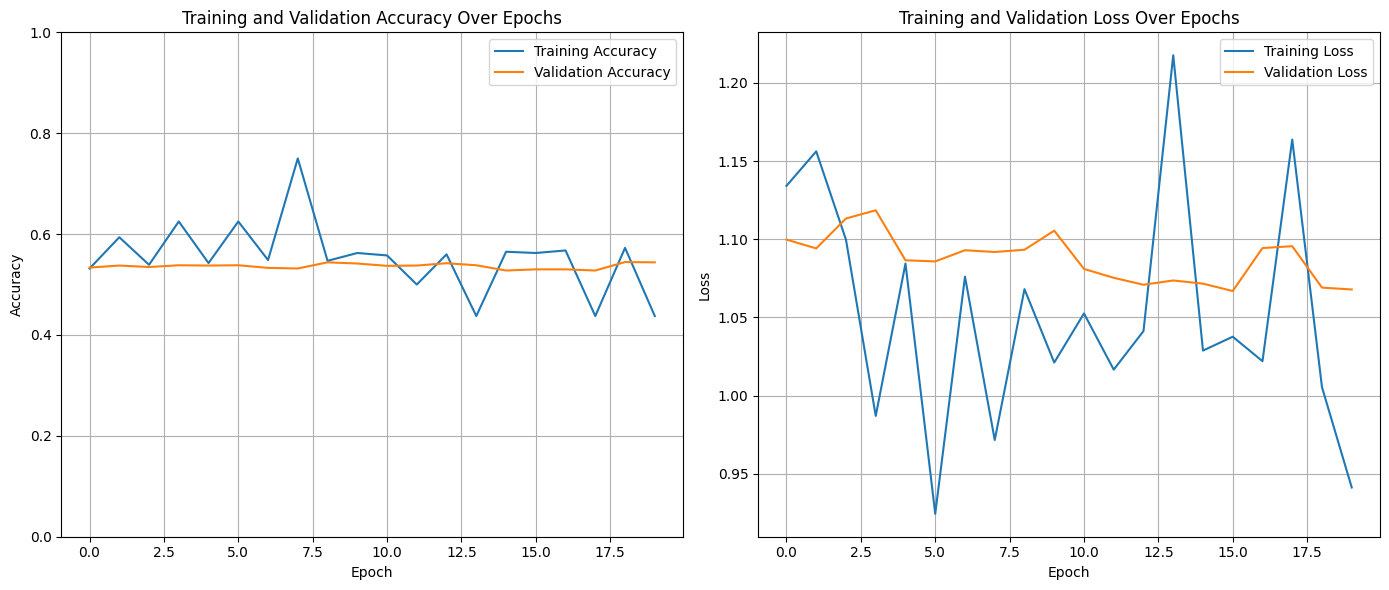

In [14]:
# Cell 6: Evaluasi dan Visualisasi Hasil Training

# Evaluasi akhir model pada set validasi
print("\nEvaluating model performance on the validation set...")
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Visualisasi Grafik Akurasi dan Loss
plt.figure(figsize=(14, 6))

# Plot Akurasi
plt.subplot(1, 2, 1) # (rows, columns, panel_number)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim([0, 1]) # Akurasi dari 0 hingga 1

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout() # Menyesuaikan tata letak untuk mencegah tumpang tindih
plt.show()